# Part B: Unsupervised Learning — County Mortality & Socioeconomic Clustering

You downloaded two richer files from CDC WONDER:

| File | What it contains | Columns |
|------|-----------------|---------|
| **Single Race** | County × Year with **Population & Crude Rate** | Deaths, Population, Crude Rate |
| **Multiple Race** | County × Year × **Race** with death counts | Deaths by race (White, Black, Hispanic, etc.) |

Together these give us:
- **County-level death counts + population + rates** (Single Race file)
- **Racial demographic breakdown** (Multiple Race file)
- **5 years of data** (2018–2022) for temporal trajectory analysis

## Extract Single Race Data

   1. Load CDC WONDER File 1: Single Race (County × Year → Deaths, Population, Rate)
   2. Source: Underlying Cause of Death, 2018-2023


In [1]:
import pandas as pd
import numpy as np
import requests
import warnings, time
import json
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:


single_race_path =  "Underlying Cause of Death, 2018-2023, Single Race.txt"
print(" Loading CDC WONDER — Single Race (County × Year)...")
print("=" * 80)

# CDC WONDER files are tab-delimited with a "---" notes footer
# Use pandas read_csv with proper settings
df_single = pd.read_csv(
    single_race_path,
    sep='\t',
    dtype=str,                          # Read everything as string first
    na_values=['Missing', 'Not Applicable'],
    comment=None
)

# Stop at the "---" notes section: rows where Notes == "---" mark the footer
footer_idx = df_single[df_single['Notes'] == '---'].index
if len(footer_idx) > 0:
    df_single = df_single.iloc[:footer_idx[0]].copy()

# Clean column names
df_single.columns = df_single.columns.str.strip()

# Standardize FIPS to 5-digit zero-padded
df_single['fips'] = df_single['County Code'].astype(str).str.zfill(5)
df_single['Year'] = pd.to_numeric(df_single['Year'], errors='coerce')

# Deaths — numeric (rows with <10 deaths are excluded by CDC WONDER)
df_single['Deaths'] = pd.to_numeric(df_single['Deaths'], errors='coerce')

# Population
df_single['Population'] = pd.to_numeric(df_single['Population'], errors='coerce')

# Crude Rate — handle "Unreliable" flag (rates based on <20 deaths)
df_single['Rate_Unreliable'] = df_single['Crude Rate'].astype(str).str.contains('Unreliable', case=False, na=False)
df_single['Crude_Rate'] = pd.to_numeric(
    df_single['Crude Rate'].astype(str).str.replace('Unreliable', '', regex=False).str.strip(),
    errors='coerce'
)

# ── Drop unreliable rows (deaths < 20) — CDC flags these as statistically
#    unreliable due to wide confidence intervals. Keeping them would introduce
#    noisy, inflated per-capita rates from small death counts. ──
n_before = len(df_single)
df_single = df_single[~df_single['Rate_Unreliable']].copy()
print(f"Dropped {n_before - len(df_single):,} unreliable rows (deaths < 20), kept {len(df_single):,}")

# Drop Notes column (empty) and redundant columns
df_single = df_single.drop(columns=['Notes', 'Year Code', 'County Code', 'State Code', 'Crude Rate'], errors='ignore')

print(f"Loaded: {len(df_single):,} rows")
print(f"Years: {df_single['Year'].min():.0f} – {df_single['Year'].max():.0f}")
print(f"Unique counties: {df_single['fips'].nunique():,}")
print(f"Unreliable rates: {df_single['Rate_Unreliable'].sum():,} ({df_single['Rate_Unreliable'].mean()*100:.1f}%)")
print(f"Missing values:\n{df_single.isnull().sum()[df_single.isnull().sum() > 0]}")
print(f"\nColumns: {list(df_single.columns)}")
print(f"\n First 10 rows:")
display(df_single.head(10))
print(f"\n Summary statistics:")
display(df_single[['Deaths', 'Population', 'Crude_Rate']].describe().round(2))

 Loading CDC WONDER — Single Race (County × Year)...
Dropped 3,262 unreliable rows (deaths < 20), kept 6,323
Loaded: 6,323 rows
Years: 2018 – 2023
Unique counties: 1,340
Unreliable rates: 0 (0.0%)
Missing values:
Population    16
Crude_Rate    16
dtype: int64

Columns: ['State', 'County', 'Year', 'Deaths', 'Population', 'fips', 'Rate_Unreliable', 'Crude_Rate']

 First 10 rows:


,State,County,Year,Deaths,Population,fips,Rate_Unreliable,Crude_Rate
4,Alabama,"Baldwin County, AL",2018,53,218022.0,01003,False,24.3
5,Alabama,"Baldwin County, AL",2019,61,223234.0,01003,False,27.3
6,Alabama,"Baldwin County, AL",2020,107,229287.0,01003,False,46.7
7,Alabama,"Baldwin County, AL",2021,139,239294.0,01003,False,58.1
8,Alabama,"Baldwin County, AL",2022,120,246435.0,01003,False,48.7
9,Alabama,"Baldwin County, AL",2023,113,253507.0,01003,False,44.6
16,Alabama,"Blount County, AL",2021,25,59041.0,01009,False,42.3
17,Alabama,"Blount County, AL",2022,23,59512.0,01009,False,38.6
18,Alabama,"Blount County, AL",2023,28,59816.0,01009,False,46.8
20,Alabama,"Calhoun County, AL",2018,26,114277.0,01015,False,22.8



 Summary statistics:


,Deaths,Population,Crude_Rate
count,6323.00,6307.00,6307.00
mean,122.50,275235.84,52.90
std,223.36,535700.35,27.88
min,20.00,5140.00,9.30
25%,30.00,64716.50,34.70
50%,53.00,119089.00,47.60
75%,117.00,264627.00,63.80
max,4202.00,10105518.00,466.90


## Multi Race Data

In [3]:
# =============================================================================
# Load CDC WONDER File 2: Multiple Race (County × Year × Race → Deaths)
# NOTE: No Population/Rate columns (CDC removes them when race is a group-by)
# =============================================================================


multi_race_path = "Underlying Cause of Death, 2018-2023, Multiple.txt"

df_multi = pd.read_csv(
    multi_race_path,
    sep='\t',
    dtype=str,
    na_values=['Missing', 'Not Applicable'],
    comment=None
)

# Stop at the "---" notes footer
footer_idx = df_multi[df_multi['Notes'] == '---'].index
if len(footer_idx) > 0:
    df_multi = df_multi.iloc[:footer_idx[0]].copy()

df_multi.columns = df_multi.columns.str.strip()

# Clean up
df_multi['fips'] = df_multi['County Code'].astype(str).str.zfill(5)
df_multi['Year'] = pd.to_numeric(df_multi['Year'], errors='coerce')
df_multi['Deaths'] = pd.to_numeric(df_multi['Deaths'], errors='coerce')

# Rename the race column for clarity
if 'Single/Multi Race 31' in df_multi.columns:
    df_multi.rename(columns={'Single/Multi Race 31': 'Race'}, inplace=True)

# Drop unnecessary columns
df_multi = df_multi.drop(columns=['Notes', 'Year Code', 'County Code', 'State Code',
                                   'Single/Multi Race 31 Code'], errors='ignore')

print(f"Loaded: {len(df_multi):,} rows")
print(f"Years: {df_multi['Year'].min():.0f} – {df_multi['Year'].max():.0f}")
print(f"Unique counties: {df_multi['fips'].nunique():,}")
print(f"\nRace categories ({df_multi['Race'].nunique()}):")
print(df_multi['Race'].value_counts())
print(f"\nColumns: {list(df_multi.columns)}")
print(f"\nSample rows:")
display(df_multi.head(15))

Loaded: 11,566 rows
Years: 2018 – 2023
Unique counties: 1,875

Race categories (12):
Race
White (only)                                                8945
Black (only)                                                1898
AIAN (American Indian or Alaskan Native) (only)              378
Asian (only)                                                 192
AIAN and White                                                49
Black and White                                               38
Asian and White                                               28
NHOPI (Native Hawaiian or Other Pacific Islander) (only)      14
AIAN and Asian                                                 6
Asian and NHOPI                                                6
NHOPI and White                                                6
Asian, NHOPI, and White                                        6
Name: count, dtype: int64

Columns: ['State', 'County', 'Year', 'Race', 'Deaths', 'fips']

Sample rows:


,State,County,Year,Race,Deaths,fips
0,Alabama,"Autauga County, AL",2018,White (only),10,01001
1,Alabama,"Autauga County, AL",2021,White (only),13,01001
2,Alabama,"Autauga County, AL",2022,White (only),11,01001
3,Alabama,"Autauga County, AL",2023,White (only),12,01001
4,Alabama,"Baldwin County, AL",2018,White (only),52,01003
5,Alabama,"Baldwin County, AL",2019,White (only),58,01003
6,Alabama,"Baldwin County, AL",2020,White (only),97,01003
7,Alabama,"Baldwin County, AL",2020,Black (only),10,01003
8,Alabama,"Baldwin County, AL",2021,White (only),130,01003
9,Alabama,"Baldwin County, AL",2022,White (only),110,01003


## Merge Single and Multiple Race Datasets

In [4]:
# =============================================================================
# Pivot the Multi-Race data → One row per county-year with race columns
# Then merge with Single Race data (which has Population & Crude Rate)
# =============================================================================

print("Combining Both CDC WONDER Files...")
print("=" * 80)

# ── Pivot race data: county-year rows, race columns with death counts ──
df_race_pivot = df_multi.pivot_table(
    index=['fips', 'State', 'County', 'Year'],
    columns='Race',
    values='Deaths',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Flatten column names
df_race_pivot.columns = [
    f"Deaths_{col.replace(' ', '_').replace('(', '').replace(')', '')}" 
    if col not in ['fips', 'State', 'County', 'Year'] else col
    for col in df_race_pivot.columns
]

# Total deaths from race breakdown (for cross-check)
death_cols = [c for c in df_race_pivot.columns if c.startswith('Deaths_')]
df_race_pivot['Deaths_Race_Total'] = df_race_pivot[death_cols].sum(axis=1)

print(f"📊 Race pivot: {df_race_pivot.shape}")
print(f"   Race death columns: {death_cols}")

# ── Merge: Single Race (Population, Rate) + Race Pivot (demographic breakdown) ──
df_wonder_combined = pd.merge(
    df_single[['fips', 'State', 'County', 'Year', 'Deaths', 'Population', 'Crude_Rate', 'Rate_Unreliable']],
    df_race_pivot,
    on=['fips', 'Year'],
    how='outer',
    suffixes=('', '_race')
)

# Use the Single Race deaths as primary (includes all races), fill from race total where missing
df_wonder_combined['Deaths'] = df_wonder_combined['Deaths'].fillna(df_wonder_combined['Deaths_Race_Total'])

# Fill State/County from either source
for col in ['State', 'County']:
    if f'{col}_race' in df_wonder_combined.columns:
        df_wonder_combined[col] = df_wonder_combined[col].fillna(df_wonder_combined[f'{col}_race'])
        df_wonder_combined.drop(columns=[f'{col}_race'], inplace=True)

print(f"\nCombined dataset: {df_wonder_combined.shape[0]:,} county-year rows × {df_wonder_combined.shape[1]} columns")
print(f"Years: {df_wonder_combined['Year'].min():.0f} – {df_wonder_combined['Year'].max():.0f}")
print(f"Unique counties: {df_wonder_combined['fips'].nunique():,}")
print(f"\nMissing values:")
missing = df_wonder_combined.isnull().sum()
print(missing[missing > 0])
print(f"\nAll columns: {list(df_wonder_combined.columns)}")
print(f"\nSample rows:")
display(df_wonder_combined.head(10))
print(f"\nKey statistics:")
display(df_wonder_combined[['Deaths', 'Population', 'Crude_Rate']].describe().round(2))

Combining Both CDC WONDER Files...
📊 Race pivot: (9046, 17)
   Race death columns: ['Deaths_AIAN_American_Indian_or_Alaskan_Native_only', 'Deaths_AIAN_and_Asian', 'Deaths_AIAN_and_White', 'Deaths_Asian_only', 'Deaths_Asian_and_NHOPI', 'Deaths_Asian_and_White', 'Deaths_Asian,_NHOPI,_and_White', 'Deaths_Black_only', 'Deaths_Black_and_White', 'Deaths_NHOPI_Native_Hawaiian_or_Other_Pacific_Islander_only', 'Deaths_NHOPI_and_White', 'Deaths_White_only']

Combined dataset: 9,047 county-year rows × 21 columns
Years: 2018 – 2023
Unique counties: 1,875

Missing values:
Population                                                     2740
Crude_Rate                                                     2740
Rate_Unreliable                                                2724
Deaths_AIAN_American_Indian_or_Alaskan_Native_only                1
Deaths_AIAN_and_Asian                                             1
Deaths_AIAN_and_White                                             1
Deaths_Asian_only         

,fips,State,County,Year,Deaths,Population,Crude_Rate,Rate_Unreliable,Deaths_AIAN_American_Indian_or_Alaskan_Native_only,Deaths_AIAN_and_Asian,...,Deaths_Asian_only,Deaths_Asian_and_NHOPI,Deaths_Asian_and_White,"Deaths_Asian,_NHOPI,_and_White",Deaths_Black_only,Deaths_Black_and_White,Deaths_NHOPI_Native_Hawaiian_or_Other_Pacific_Islander_only,Deaths_NHOPI_and_White,Deaths_White_only,Deaths_Race_Total
0,01001,Alabama,"Autauga County, AL",2018,10.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0
1,01001,Alabama,"Autauga County, AL",2021,13.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0
2,01001,Alabama,"Autauga County, AL",2022,11.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,11.0
3,01001,Alabama,"Autauga County, AL",2023,12.0,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0
4,01003,Alabama,"Baldwin County, AL",2018,53.0,218022.0,24.3,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,52.0
5,01003,Alabama,"Baldwin County, AL",2019,61.0,223234.0,27.3,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,58.0
6,01003,Alabama,"Baldwin County, AL",2020,107.0,229287.0,46.7,False,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,97.0,107.0
7,01003,Alabama,"Baldwin County, AL",2021,139.0,239294.0,58.1,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,130.0
8,01003,Alabama,"Baldwin County, AL",2022,120.0,246435.0,48.7,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,110.0
9,01003,Alabama,"Baldwin County, AL",2023,113.0,253507.0,44.6,False,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,99.0,111.0



Key statistics:


,Deaths,Population,Crude_Rate
count,9047.00,6307.00,6307.00
mean,89.60,275235.84,52.90
std,193.34,535700.35,27.88
min,10.00,5140.00,9.30
25%,16.00,64716.50,34.70
50%,32.00,119089.00,47.60
75%,79.00,264627.00,63.80
max,4202.00,10105518.00,466.90


## We'll now scale up to **all U.S. counties**, merge CDC mortality with ACS socioeconomic data, and apply unsupervised methods:
1. **PCA** — reduce ACS dimensions
2. **K-Means** — identify county clusters
3. **Hierarchical Clustering** — dendrogram analysis
4. **DBSCAN** — outlier detection
5. **t-SNE / UMAP** — 2D visualization

## Step 1: Download ACS data for MULTIPLE YEARS & merge with CDC WONDER by fips+year

  CDC WONDER covers 2018-2023.  ACS 5-Year Estimates are available for 2018-2022.
  We download ACS for each year 2018-2022, join on (fips, year) so that each
  year's mortality is paired with that SAME year's socioeconomic snapshot, then
  average the year-matched pairs per county.  CDC year 2023 (no ACS match) is
  excluded from the join but we report how many rows are lost.


In [5]:

warnings.filterwarnings('ignore')

acs_vars = {
    'B19013_001E': 'Median_Household_Income',
    'B17001_001E': 'Poverty_Universe',
    'B17001_002E': 'Population_Below_Poverty',
    'B23025_003E': 'Civilian_Labor_Force',
    'B23025_005E': 'Unemployed',
    'B15003_001E': 'Education_Universe',
    'B15003_022E': 'Bachelors_Degree',
    'B15003_023E': 'Masters_Degree',
    'B15003_024E': 'Professional_Degree',
    'B15003_025E': 'Doctorate_Degree',
    'B01003_001E': 'Total_Population',
    'B02001_002E': 'White_Alone',
    'B02001_003E': 'Black_Alone',
    'B03003_003E': 'Hispanic_Latino',
    'B25077_001E': 'Median_Home_Value',
    'B01002_001E': 'Median_Age',
}
var_codes = ','.join(acs_vars.keys())

# ── Download ACS for each year 2018-2022 ──
acs_years = [2018, 2019, 2020, 2021, 2022]
acs_frames = []

print("Downloading ACS 5-Year Estimates for ALL U.S. counties (2018–2022)...")
print("=" * 80)

for yr in acs_years:
    url = f"https://api.census.gov/data/{yr}/acs/acs5"
    params = {'get': f'NAME,{var_codes}', 'for': 'county:*', 'in': 'state:*'}
    try:
        resp = requests.get(url, params=params, timeout=120)
        resp.raise_for_status()
        data = resp.json()
        df_yr = pd.DataFrame(data[1:], columns=data[0])
        df_yr.rename(columns=acs_vars, inplace=True)
        df_yr['fips'] = df_yr['state'].str.zfill(2) + df_yr['county'].str.zfill(3)
        df_yr['Year'] = yr
        acs_frames.append(df_yr)
        print(f"{yr}: {len(df_yr):,} counties")
    except Exception as e:
        print(f"{yr}: FAILED — {e}")
    time.sleep(0.5)   # be polite to the API

df_acs_all = pd.concat(acs_frames, ignore_index=True)

# Convert numeric
for col in acs_vars.values():
    df_acs_all[col] = pd.to_numeric(df_acs_all[col], errors='coerce')

# Compute derived rates
college_cols = ['Bachelors_Degree', 'Masters_Degree', 'Professional_Degree', 'Doctorate_Degree']
df_acs_all['Poverty_Rate']       = (df_acs_all['Population_Below_Poverty'] / df_acs_all['Poverty_Universe'] * 100).round(2)
df_acs_all['Unemployment_Rate']  = (df_acs_all['Unemployed'] / df_acs_all['Civilian_Labor_Force'] * 100).round(2)
df_acs_all['Pct_College']        = (df_acs_all[college_cols].sum(axis=1) / df_acs_all['Education_Universe'] * 100).round(2)
df_acs_all['Pct_White']          = (df_acs_all['White_Alone']    / df_acs_all['Total_Population'] * 100).round(2)
df_acs_all['Pct_Black']          = (df_acs_all['Black_Alone']    / df_acs_all['Total_Population'] * 100).round(2)
df_acs_all['Pct_Hispanic']       = (df_acs_all['Hispanic_Latino'] / df_acs_all['Total_Population'] * 100).round(2)

print(f"\nACS panel: {len(df_acs_all):,} county-year rows  ({df_acs_all['Year'].min()}–{df_acs_all['Year'].max()})")
print(f"   Unique counties: {df_acs_all['fips'].nunique():,}")

# ── Year-matched join: CDC WONDER (fips+Year) × ACS (fips+Year) ──
acs_keep = ['fips', 'Year', 'NAME', 'Total_Population',
            'Median_Household_Income', 'Median_Home_Value', 'Median_Age',
            'Poverty_Rate', 'Unemployment_Rate', 'Pct_College',
            'Pct_White', 'Pct_Black', 'Pct_Hispanic']

# CDC WONDER already has Year in df_wonder_combined
cdc_years = set(df_wonder_combined['Year'].dropna().unique())
acs_yrs   = set(df_acs_all['Year'].unique())
overlap   = sorted(cdc_years & acs_yrs)
print(f"\nCDC years: {sorted(cdc_years)}")
print(f"ACS years: {sorted(acs_yrs)}")
print(f"Overlapping years for join: {overlap}")

# Join on fips + Year
df_matched = pd.merge(
    df_wonder_combined,
    df_acs_all[acs_keep],
    on=['fips', 'Year'],
    how='inner'
)
print(f"\nYear-matched join: {len(df_matched):,} county-year rows")

lost = len(df_wonder_combined) - len(df_wonder_combined[df_wonder_combined['Year'].isin(overlap)])
print(f"   Excluded (no ACS match): {lost:,} CDC rows (year 2023)")

# ── Aggregate to county-level: mean across matched years ──
df_wonder_agg = df_matched.groupby('fips').agg(
    State=('State', 'first'),
    County=('County', 'first'),
    Avg_Deaths=('Deaths', 'mean'),
    Avg_Population=('Population', 'mean'),
    Avg_Crude_Rate=('Crude_Rate', 'mean'),
    Num_Years=('Year', 'nunique'),
    Median_Household_Income=('Median_Household_Income', 'mean'),
    Median_Home_Value=('Median_Home_Value', 'mean'),
    Median_Age=('Median_Age', 'mean'),
    Poverty_Rate=('Poverty_Rate', 'mean'),
    Unemployment_Rate=('Unemployment_Rate', 'mean'),
    Pct_College=('Pct_College', 'mean'),
    Pct_White=('Pct_White', 'mean'),
    Pct_Black=('Pct_Black', 'mean'),
    Pct_Hispanic=('Pct_Hispanic', 'mean'),
    Total_Population=('Total_Population', 'mean'),
).reset_index()

# For counties missing Crude_Rate, compute from Deaths/Population
mask = df_wonder_agg['Avg_Crude_Rate'].isna() & df_wonder_agg['Avg_Population'].notna()
df_wonder_agg.loc[mask, 'Avg_Crude_Rate'] = (
    df_wonder_agg.loc[mask, 'Avg_Deaths'] / df_wonder_agg.loc[mask, 'Avg_Population'] * 100_000
).round(1)

# Round derived columns
for c in ['Median_Household_Income','Median_Home_Value','Median_Age','Poverty_Rate',
          'Unemployment_Rate','Pct_College','Pct_White','Pct_Black','Pct_Hispanic']:
    df_wonder_agg[c] = df_wonder_agg[c].round(2)

# df_all is the final county-level dataset (no separate ACS merge needed)
df_all = df_wonder_agg.copy()

# ── Drop counties with missing Avg_Crude_Rate (no reliable mortality data) ──
n_before_filter = len(df_all)
df_all = df_all.dropna(subset=['Avg_Crude_Rate']).reset_index(drop=True)
print(f"Dropped {n_before_filter - len(df_all)} counties with missing crude rate (no reliable CDC data)")

print(f"\nFinal dataset: {len(df_all):,} counties × {df_all.shape[1]} columns")
print(f"Each county's features are averaged over {df_all['Num_Years'].median():.0f} matched years (median)")
print(f"\nColumns: {list(df_all.columns)}")
print(f"\nMissing values:\n{df_all.isnull().sum()[df_all.isnull().sum() > 0]}")
display(df_all.head())

2018: 3,220 counties
2019: 3,220 counties
2020: 3,221 counties
2021: 3,221 counties
2022: 3,222 counties

ACS panel: 16,104 county-year rows  (2018–2022)
   Unique counties: 3,231

CDC years: [2018, 2019, 2020, 2021, 2022, 2023]
ACS years: [2018, 2019, 2020, 2021, 2022]
Overlapping years for join: [2018, 2019, 2020, 2021, 2022]

Year-matched join: 7,460 county-year rows
   Excluded (no ACS match): 1,574 CDC rows (year 2023)
Dropped 524 counties with missing crude rate (no reliable CDC data)

Final dataset: 1,312 counties × 17 columns
Each county's features are averaged over 5 matched years (median)

Columns: ['fips', 'State', 'County', 'Avg_Deaths', 'Avg_Population', 'Avg_Crude_Rate', 'Num_Years', 'Median_Household_Income', 'Median_Home_Value', 'Median_Age', 'Poverty_Rate', 'Unemployment_Rate', 'Pct_College', 'Pct_White', 'Pct_Black', 'Pct_Hispanic', 'Total_Population']

Missing values:
Series([], dtype: int64)


,fips,State,County,Avg_Deaths,Avg_Population,Avg_Crude_Rate,Num_Years,Median_Household_Income,Median_Home_Value,Median_Age,Poverty_Rate,Unemployment_Rate,Pct_College,Pct_White,Pct_Black,Pct_Hispanic,Total_Population
0,01003,Alabama,"Baldwin County, AL",96.000000,231254.4,41.02,5,62284.6,218380.0,43.22,9.90,3.95,32.03,85.29,8.92,4.62,219955.400000
1,01009,Alabama,"Blount County, AL",20.200000,59276.5,40.45,5,51449.0,137140.0,40.88,13.82,4.93,13.72,93.74,1.41,9.38,58208.400000
2,01015,Alabama,"Calhoun County, AL",44.400000,114622.2,38.66,5,49579.2,123420.0,39.54,17.57,7.62,18.80,73.17,21.21,3.87,115325.400000
3,01021,Alabama,"Chilton County, AL",17.800000,45884.0,47.90,5,52701.0,113460.0,39.30,16.97,6.26,13.60,82.29,9.31,7.89,44425.800000
4,01033,Alabama,"Colbert County, AL",18.666667,57474.0,43.50,3,52077.0,133000.0,42.17,15.49,3.84,18.02,78.42,16.21,3.04,56276.666667


## Step 2: Feature Matrix Preparation & Standardization

Impute the dataset using KNN and starndardize using StandardScaler to achieve 0 Mean and 1 Std 

In [6]:


# Features for clustering (CDC WONDER mortality rate + ACS socioeconomic)
feature_cols = [
    'Avg_Crude_Rate',           # drug overdose mortality rate (CDC WONDER actual)
    'Median_Household_Income',
    'Median_Home_Value',
    'Median_Age',
    'Poverty_Rate',
    'Unemployment_Rate',
    'Pct_College',
    'Pct_White',
    'Pct_Black',
    'Pct_Hispanic',
]

# Build feature matrix
X_raw = df_all[feature_cols].copy()

# KNN impute any remaining NaN (rare but possible for some ACS estimates)
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_raw), columns=feature_cols, index=df_all.index)

# Standardize (mean=0, std=1) — required for PCA & distance-based clustering
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=feature_cols, index=df_all.index)

print(f"Feature matrix: {X_scaled.shape[0]:,} counties × {X_scaled.shape[1]} features")
print(f"\nFeatures used:")
for f in feature_cols:
    print(f"   • {f}")
print(f"\nScaled summary (should be ~mean=0, std=1):")
display(X_scaled.describe().round(2))

Feature matrix: 1,312 counties × 10 features

Features used:
   • Avg_Crude_Rate
   • Median_Household_Income
   • Median_Home_Value
   • Median_Age
   • Poverty_Rate
   • Unemployment_Rate
   • Pct_College
   • Pct_White
   • Pct_Black
   • Pct_Hispanic

Scaled summary (should be ~mean=0, std=1):


,Avg_Crude_Rate,Median_Household_Income,Median_Home_Value,Median_Age,Poverty_Rate,Unemployment_Rate,Pct_College,Pct_White,Pct_Black,Pct_Hispanic
count,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00,1312.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.49,-2.08,-1.47,-3.24,-2.05,-1.89,-1.94,-4.46,-0.77,-0.80
25%,-0.61,-0.66,-0.62,-0.63,-0.71,-0.67,-0.77,-0.53,-0.65,-0.57
50%,-0.20,-0.20,-0.28,-0.04,-0.09,-0.15,-0.22,0.30,-0.43,-0.35
75%,0.35,0.43,0.29,0.55,0.55,0.47,0.58,0.77,0.22,0.12
max,14.06,5.44,8.15,5.65,8.03,6.89,4.59,1.20,5.33,6.67


# Step 3: PCA — Dimensionality Reduction


Components for ≥80% variance: 4 (cumulative = 82.1%)


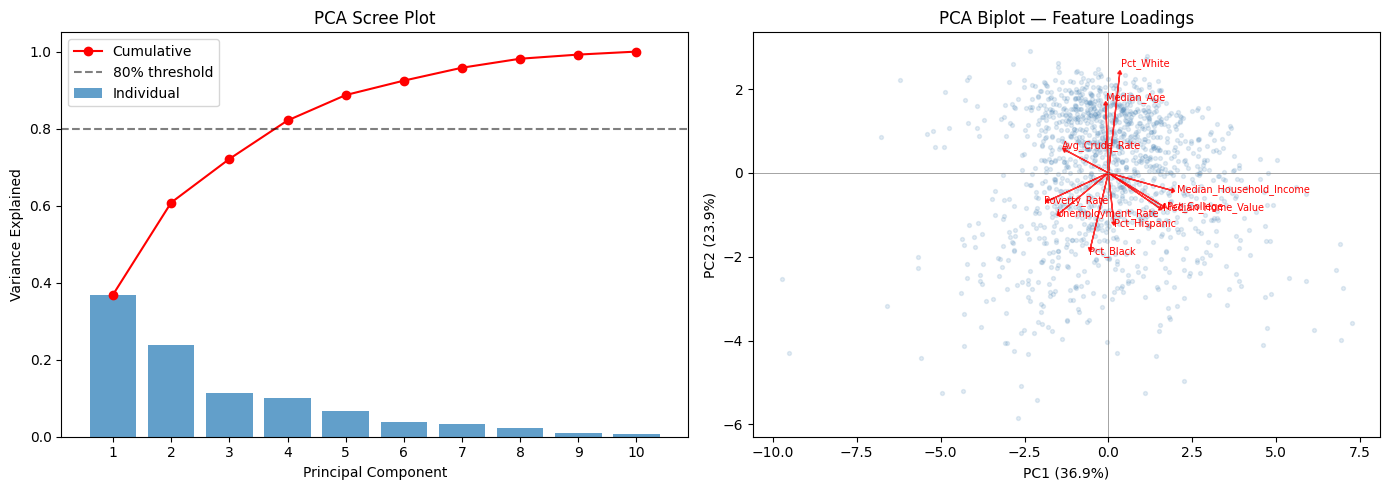


PCA loadings (top features per component):


,PC1,PC2,PC3,PC4
Avg_Crude_Rate,-0.320,0.136,0.159,0.538
Median_Household_Income,0.474,-0.105,0.019,0.185
Median_Home_Value,0.380,-0.209,0.216,0.428
Median_Age,-0.019,0.406,-0.111,0.553
Poverty_Rate,-0.449,-0.166,0.109,-0.020
Unemployment_Rate,-0.366,-0.241,0.174,0.322
Pct_College,0.407,-0.198,-0.108,0.167
Pct_White,0.084,0.591,0.126,-0.176
Pct_Black,-0.134,-0.449,-0.556,0.046
Pct_Hispanic,0.040,-0.293,0.733,-0.148


In [7]:
# =============================================================================
# Step 3: PCA — Dimensionality Reduction
# =============================================================================


# Fit PCA on all components first to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumvar) + 1), cumvar, 'ro-', label='Cumulative')
axes[0].axhline(y=0.80, color='k', linestyle='--', alpha=0.5, label='80% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(cumvar) + 1))

# Determine n_components for 80% variance
n_comp = np.argmax(cumvar >= 0.80) + 1
print(f"Components for ≥80% variance: {n_comp} (cumulative = {cumvar[n_comp-1]:.1%})")

# Fit PCA with chosen n_components
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)

# Biplot (PC1 vs PC2 with feature loadings)
loadings = pca.components_.T  # shape: (n_features, n_comp)
ax = axes[1]
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.15, s=8, c='steelblue')
for i, feat in enumerate(feature_cols):
    ax.arrow(0, 0, loadings[i, 0] * 4, loadings[i, 1] * 4,
             head_width=0.12, head_length=0.08, fc='red', ec='red', alpha=0.8)
    ax.text(loadings[i, 0] * 4.3, loadings[i, 1] * 4.3, feat, fontsize=7, color='red')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA Biplot — Feature Loadings')
ax.axhline(0, color='grey', lw=0.5); ax.axvline(0, color='grey', lw=0.5)

plt.tight_layout()
plt.show()

print(f"\nPCA loadings (top features per component):")
loadings_df = pd.DataFrame(pca.components_.T, index=feature_cols,
                           columns=[f'PC{i+1}' for i in range(n_comp)])
display(loadings_df.round(3))



# Step 4: K-Means Clustering — Elbow + Silhouette Analysis



Evaluating K-Means for k = 2..10...
  k=2: Silhouette=0.247  CH=454  DB=1.446
  k=3: Silhouette=0.296  CH=493  DB=1.242
  k=4: Silhouette=0.320  CH=451  DB=1.150
  k=5: Silhouette=0.263  CH=462  DB=1.142
  k=6: Silhouette=0.262  CH=440  DB=1.098
  k=7: Silhouette=0.257  CH=432  DB=1.104
  k=8: Silhouette=0.243  CH=419  DB=1.121
  k=9: Silhouette=0.242  CH=406  DB=1.138
  k=10: Silhouette=0.219  CH=390  DB=1.179


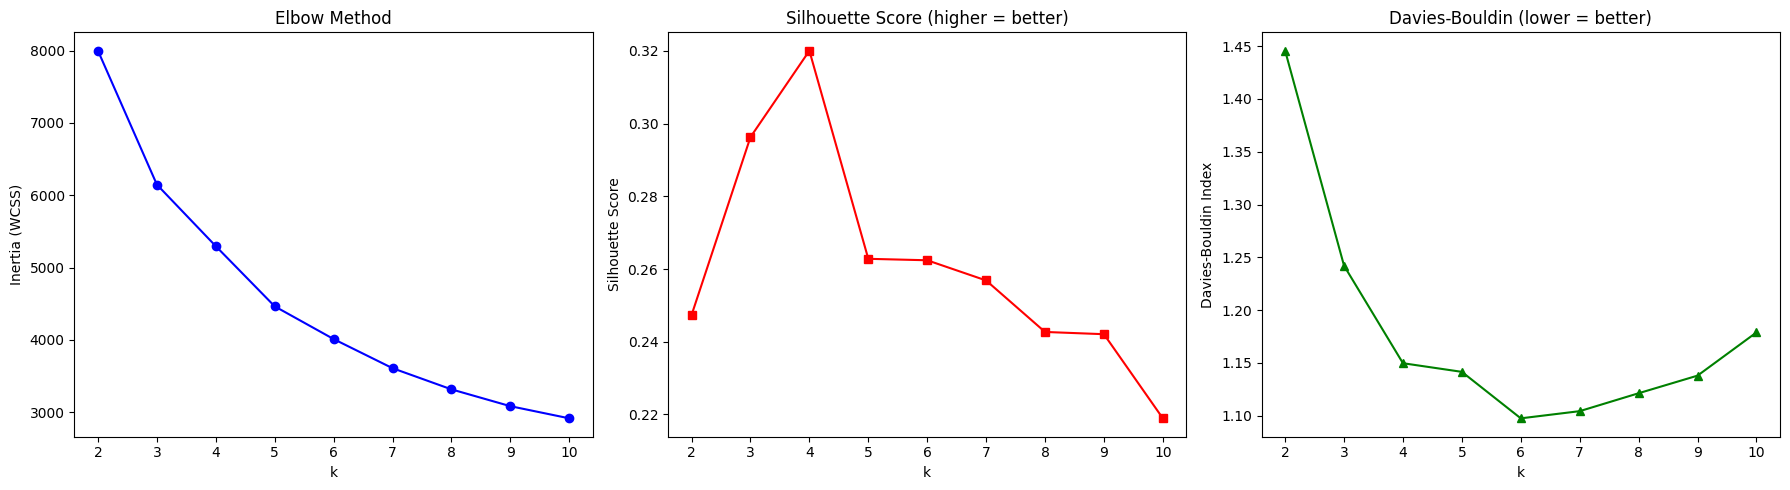


Best k by silhouette: 4 (score = 0.320)

Cluster distribution:
kmeans_cluster
0    126
1    676
2    198
3    312
Name: count, dtype: int64


In [8]:

K_range = range(2, 11)
inertias, sil_scores, ch_scores, db_scores = [], [], [], []

print("Evaluating K-Means for k = 2..10...")
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, labels))
    ch_scores.append(calinski_harabasz_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))
    print(f"  k={k}: Silhouette={sil_scores[-1]:.3f}  CH={ch_scores[-1]:.0f}  DB={db_scores[-1]:.3f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method'); axes[0].set_xticks(list(K_range))

# Silhouette plot
axes[1].plot(K_range, sil_scores, 'rs-')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (higher = better)'); axes[1].set_xticks(list(K_range))

# Davies-Bouldin plot
axes[2].plot(K_range, db_scores, 'g^-')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin (lower = better)'); axes[2].set_xticks(list(K_range))

plt.tight_layout()
plt.show()

# Choose optimal k (best silhouette)
best_k = list(K_range)[np.argmax(sil_scores)]
print(f"\nBest k by silhouette: {best_k} (score = {max(sil_scores):.3f})")

# Fit final K-Means
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
df_all['kmeans_cluster'] = kmeans_final.fit_predict(X_pca)

print(f"\nCluster distribution:")
print(df_all['kmeans_cluster'].value_counts().sort_index())


# Step 5: Hierarchical (Agglomerative) Clustering — Dendrogram



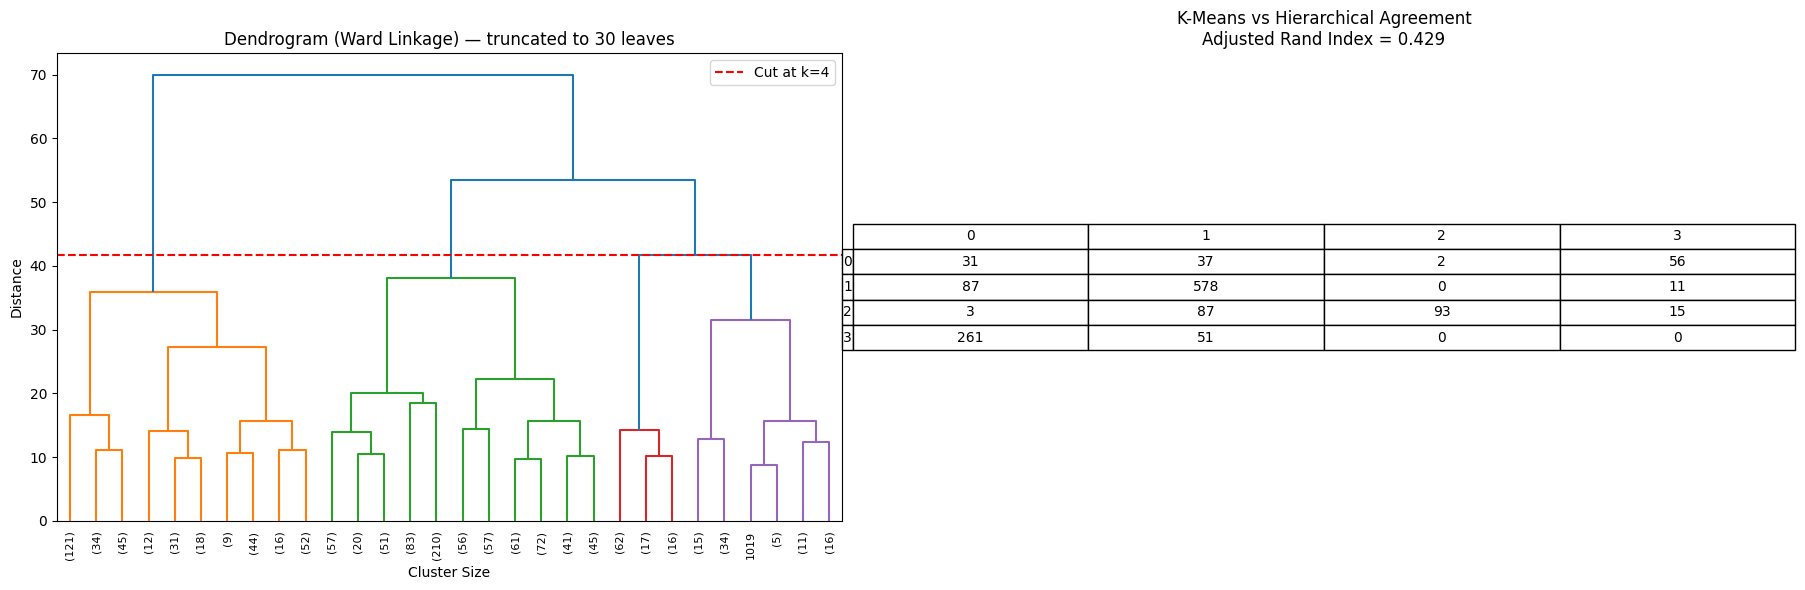

Hierarchical cluster distribution:
hier_cluster
0    382
1    753
2     95
3     82
Name: count, dtype: int64

🔗 Adjusted Rand Index (K-Means vs Hierarchical): 0.429
   (1.0 = perfect agreement, 0.0 = random)


In [9]:


# Ward linkage (minimizes within-cluster variance, like K-Means)
Z = linkage(X_pca, method='ward')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Full dendrogram (truncated for readability)
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=8,
           ax=axes[0], color_threshold=Z[-best_k+1, 2])
axes[0].set_title(f'Dendrogram (Ward Linkage) — truncated to 30 leaves')
axes[0].set_xlabel('Cluster Size'); axes[0].set_ylabel('Distance')
axes[0].axhline(y=Z[-best_k+1, 2], color='r', linestyle='--', label=f'Cut at k={best_k}')
axes[0].legend()

# Cut dendrogram at best_k
df_all['hier_cluster'] = fcluster(Z, t=best_k, criterion='maxclust') - 1  # 0-indexed

# Compare K-Means vs Hierarchical via cross-tabulation
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df_all['kmeans_cluster'], df_all['hier_cluster'])

ct = pd.crosstab(df_all['kmeans_cluster'], df_all['hier_cluster'],
                 rownames=['K-Means'], colnames=['Hierarchical'])

axes[1].axis('off')
axes[1].set_title(f'K-Means vs Hierarchical Agreement\nAdjusted Rand Index = {ari:.3f}')
table = axes[1].table(cellText=ct.values, rowLabels=ct.index, colLabels=ct.columns,
                       loc='center', cellLoc='center')
table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

print(f"Hierarchical cluster distribution:")
print(df_all['hier_cluster'].value_counts().sort_index())
print(f"\n🔗 Adjusted Rand Index (K-Means vs Hierarchical): {ari:.3f}")
print("   (1.0 = perfect agreement, 0.0 = random)")



# Step 6: DBSCAN — Density-Based Clustering & Outlier Detection


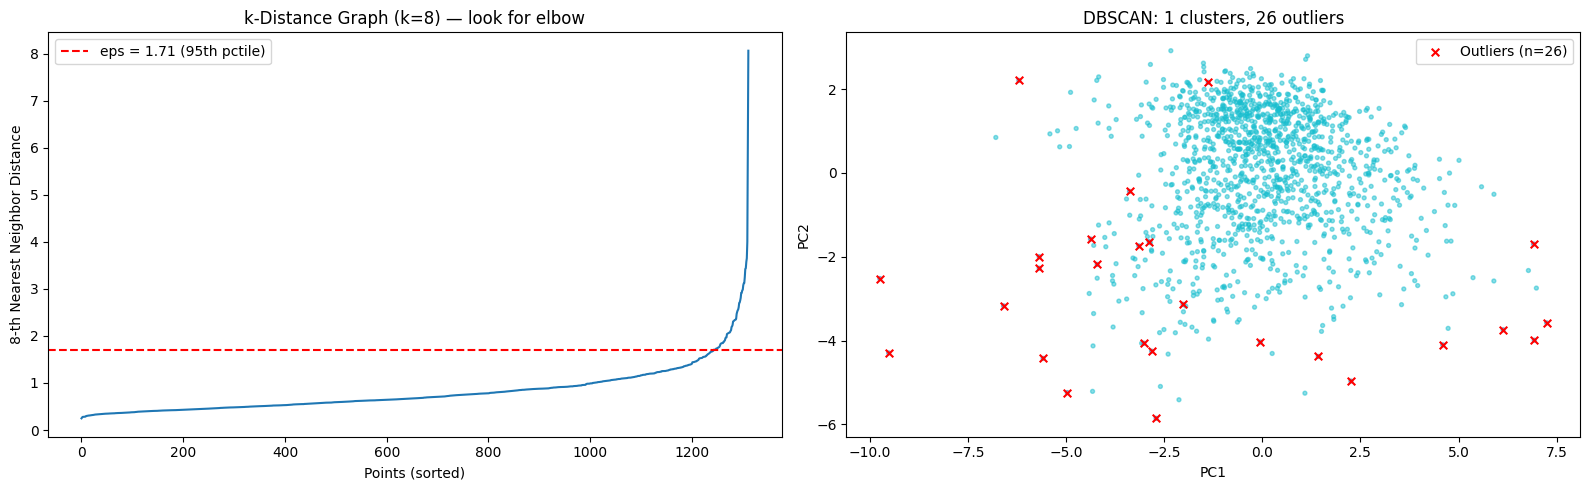

🔍 DBSCAN results (eps=1.71, min_samples=8):
   Clusters found: 1
   Outlier counties: 26 (2.0%)

📊 Cluster distribution:
dbscan_cluster
-1      26
 0    1286
Name: count, dtype: int64

🚨 Top outlier counties (unusual mortality/socioeconomic profiles):


,County,State,Avg_Crude_Rate,Median_Household_Income,Poverty_Rate
1019,"Dewey County, SD",South Dakota,466.900000,50582.00,33.03
396,"Lee County, KY",Kentucky,275.400000,30749.50,30.67
1022,"Todd County, SD",South Dakota,235.350000,28048.00,56.70
612,"Roosevelt County, MT",Montana,233.650000,45955.20,30.11
667,"McKinley County, NM",New Mexico,186.820000,37195.60,34.72
669,"Rio Arriba County, NM",New Mexico,180.740000,45310.25,22.74
674,"Socorro County, NM",New Mexico,157.200000,38846.00,30.75
480,"Baltimore city, MD",Maryland,149.300000,52771.20,20.58
33,"Apache County, AZ",Arizona,148.420000,34341.80,34.32
911,"Curry County, OR",Oregon,140.166667,53972.60,13.10


In [10]:


# Use k-distance graph to choose eps
k = 2 * X_pca.shape[1]  # rule of thumb: 2 * dimensions
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_pca)
distances, _ = nn.kneighbors(X_pca)
k_dist = np.sort(distances[:, -1])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# k-distance plot to find elbow → eps
axes[0].plot(k_dist)
axes[0].set_xlabel('Points (sorted)'); axes[0].set_ylabel(f'{k}-th Nearest Neighbor Distance')
axes[0].set_title(f'k-Distance Graph (k={k}) — look for elbow')

# Choose eps at elbow (use knee detection heuristic)
eps_val = np.percentile(k_dist, 95)  # 95th percentile as a reasonable eps
axes[0].axhline(y=eps_val, color='r', linestyle='--', label=f'eps = {eps_val:.2f} (95th pctile)')
axes[0].legend()

# Fit DBSCAN
dbscan = DBSCAN(eps=eps_val, min_samples=k)
df_all['dbscan_cluster'] = dbscan.fit_predict(X_pca)

n_clusters_db = len(set(df_all['dbscan_cluster'])) - (1 if -1 in df_all['dbscan_cluster'].values else 0)
n_outliers = (df_all['dbscan_cluster'] == -1).sum()

# Scatter PC1 vs PC2 colored by DBSCAN
colors = df_all['dbscan_cluster'].copy()
ax = axes[1]
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', s=8, alpha=0.5)
# Highlight outliers
outlier_mask = df_all['dbscan_cluster'] == -1
ax.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1],
           c='red', marker='x', s=30, label=f'Outliers (n={n_outliers})')
ax.set_xlabel(f'PC1'); ax.set_ylabel(f'PC2')
ax.set_title(f'DBSCAN: {n_clusters_db} clusters, {n_outliers} outliers')
ax.legend()

plt.tight_layout()
plt.show()

print(f"🔍 DBSCAN results (eps={eps_val:.2f}, min_samples={k}):")
print(f"   Clusters found: {n_clusters_db}")
print(f"   Outlier counties: {n_outliers} ({n_outliers/len(df_all)*100:.1f}%)")
print(f"\n📊 Cluster distribution:")
print(df_all['dbscan_cluster'].value_counts().sort_index())

if n_outliers > 0:
    print(f"\n🚨 Top outlier counties (unusual mortality/socioeconomic profiles):")
    outliers = df_all[df_all['dbscan_cluster'] == -1][['County', 'State', 'Avg_Crude_Rate',
                       'Median_Household_Income', 'Poverty_Rate']].sort_values('Avg_Crude_Rate', ascending=False)
    display(outliers.head(15))



# Step 7: Interactive Geographic Maps with Mouseover Tooltips (Plotly)


In [11]:


# ── Load county GeoJSON and extract centroids ──
print("Loading county boundaries from GeoJSON...")
with open(r"counties_geojson.json") as f:
    counties_geo = json.load(f)

centroids_list = []
for feat in counties_geo['features']:
    fips = feat['id']
    coords = feat['geometry']['coordinates']
    all_pts = []
    if feat['geometry']['type'] == 'Polygon':
        for ring in coords:
            all_pts.extend(ring)
    elif feat['geometry']['type'] == 'MultiPolygon':
        for polygon in coords:
            for ring in polygon:
                all_pts.extend(ring)
    if all_pts:
        lon = np.mean([p[0] for p in all_pts])
        lat = np.mean([p[1] for p in all_pts])
        centroids_list.append({'fips': fips, 'lon': lon, 'lat': lat})

df_centroids = pd.DataFrame(centroids_list)
print(f"{len(df_centroids):,} county centroids extracted")

# ── Merge lat/lon into dataset ──
df_map = df_all.merge(df_centroids, on='fips', how='left')
df_map['is_outlier'] = df_map['dbscan_cluster'] == -1

# Filter to continental US
continental = df_map[
    (df_map['lon'].between(-130, -65)) &
    (df_map['lat'].between(24, 50))
].copy()

# ── Build cluster label text for tooltips ──
cluster_labels = {0: 'Affluent/Urban', 1: 'High-Poverty/Deep South', 
                  2: 'Middle America/Rural', 3: 'Minority-Concentrated/Suburban'}
continental['Cluster_Label'] = continental['kmeans_cluster'].map(
    lambda c: f"Cluster {c}: {cluster_labels.get(c, 'Unknown')}"
)
continental['Outlier_Flag'] = continental['is_outlier'].map({True: 'DBSCAN Outlier', False: ''})

normal = continental[~continental['is_outlier']]
anomalies = continental[continental['is_outlier']]
print(f"{len(continental):,} continental counties mapped, {len(anomalies)} DBSCAN anomalies")

# For Map 1: Only show anomalies with ABOVE-MEDIAN death rates (truly concerning)
median_rate = continental['Avg_Crude_Rate'].median()
anomalies_high_mortality = anomalies[anomalies['Avg_Crude_Rate'] > median_rate]
print(f"{len(anomalies_high_mortality)} anomalies with above-median death rate (>{median_rate:.1f}/100k) shown on Map 1")

# ═══════════════════════════════════════════════════════════════════════════════
# MAP 1: Drug Overdose Mortality Heatmap with DBSCAN Anomaly Stars
# ═══════════════════════════════════════════════════════════════════════════════
fig1 = go.Figure()

# Normal counties — colored by death rate
fig1.add_trace(go.Scattergeo(
    lon=normal['lon'], lat=normal['lat'],
    marker=dict(
        size=5,
        color=normal['Avg_Crude_Rate'],
        colorscale='YlOrRd',
        cmin=normal['Avg_Crude_Rate'].quantile(0.05),
        cmax=normal['Avg_Crude_Rate'].quantile(0.95),
        colorbar=dict(title='Death Rate<br>(per 100k)', x=1.01),
        opacity=0.6,
    ),
    text=normal.apply(lambda r: (
        f"<b>{r['County']}, {r['State']}</b><br>"
        f"FIPS: {r['fips']}<br>"
        f"Death Rate: {r['Avg_Crude_Rate']:.1f}/100k<br>"
        f"Income: ${r['Median_Household_Income']:,.0f}<br>"
        f"Poverty: {r['Poverty_Rate']:.1f}%<br>"
        f"College: {r['Pct_College']:.1f}%<br>"
        f"{r['Cluster_Label']}"
    ), axis=1),
    hoverinfo='text',
    name='Counties',
))

# Anomaly counties — only those with above-median death rates (high-mortality outliers)
fig1.add_trace(go.Scattergeo(
    lon=anomalies_high_mortality['lon'], lat=anomalies_high_mortality['lat'],
    marker=dict(size=12, color='blue', symbol='star', line=dict(width=1, color='black')),
    text=anomalies_high_mortality.apply(lambda r: (
        f"<b>{r['County']}, {r['State']}</b><br>"
        f"FIPS: {r['fips']}<br>"
        f"Death Rate: {r['Avg_Crude_Rate']:.1f}/100k<br>"
        f"Income: ${r['Median_Household_Income']:,.0f}<br>"
        f"Poverty: {r['Poverty_Rate']:.1f}%<br>"
        f"College: {r['Pct_College']:.1f}%<br>"
        f"Pct White: {r['Pct_White']:.1f}% | Black: {r['Pct_Black']:.1f}% | Hispanic: {r['Pct_Hispanic']:.1f}%<br>"
        f"{r['Cluster_Label']}"
    ), axis=1),
    hoverinfo='text',
    name=f'High-Mortality Anomalies (n={len(anomalies_high_mortality)})',
))

fig1.update_geos(
    scope='usa', projection_type='albers usa',
    showland=True, landcolor='#f0f0f0',
    showlakes=True, lakecolor='white',
    showcountries=True,
)
fig1.update_layout(
    title=dict(text='Drug Overdose Mortality Rate with High-Mortality DBSCAN Anomalies', font=dict(size=16)),
    height=600, margin=dict(l=0, r=0, t=50, b=0),
    legend=dict(x=0.01, y=0.01, bgcolor='rgba(255,255,255,0.8)'),
)
fig1.show()

# ═══════════════════════════════════════════════════════════════════════════════
# MAP 2: K-Means Clusters with Mouseover (colored by cluster)
# ═══════════════════════════════════════════════════════════════════════════════
km_colors = {0: '#2196F3', 1: '#FF5722', 2: '#4CAF50', 3: '#9C27B0', 4: '#FF9800', 5: '#00BCD4'}

fig2 = go.Figure()

for c in sorted(continental['kmeans_cluster'].unique()):
    sub = continental[continental['kmeans_cluster'] == c]
    fig2.add_trace(go.Scattergeo(
        lon=sub['lon'], lat=sub['lat'],
        marker=dict(size=5, color=km_colors.get(c, '#999'), opacity=0.55),
        text=sub.apply(lambda r: (
            f"<b>{r['County']}, {r['State']}</b><br>"
            f"FIPS: {r['fips']}<br>"
            f"{r['Cluster_Label']}<br>"
            f"Death Rate: {r['Avg_Crude_Rate']:.1f}/100k<br>"
            f"Income: ${r['Median_Household_Income']:,.0f}<br>"
            f"Poverty: {r['Poverty_Rate']:.1f}%<br>"
            f"College: {r['Pct_College']:.1f}%<br>"
            f"White: {r['Pct_White']:.1f}% | Black: {r['Pct_Black']:.1f}% | Hispanic: {r['Pct_Hispanic']:.1f}%<br>"
            f"{r['Outlier_Flag']}"
        ), axis=1),
        hoverinfo='text',
        name=f'Cluster {c}: {cluster_labels.get(c, "")} (n={len(sub):,})',
    ))

# Overlay anomaly stars
fig2.add_trace(go.Scattergeo(
    lon=anomalies['lon'], lat=anomalies['lat'],
    marker=dict(size=12, color='red', symbol='star', line=dict(width=1, color='black')),
    text=anomalies.apply(lambda r: (
        f"<b>{r['County']}, {r['State']}</b><br>"
        f"FIPS: {r['fips']}<br>"
        f"{r['Cluster_Label']}<br>"
        f"Death Rate: {r['Avg_Crude_Rate']:.1f}/100k<br>"
        f"Income: ${r['Median_Household_Income']:,.0f}<br>"
        f"Poverty: {r['Poverty_Rate']:.1f}%<br>"
        f"White: {r['Pct_White']:.1f}% | Black: {r['Pct_Black']:.1f}% | Hispanic: {r['Pct_Hispanic']:.1f}%"
    ), axis=1),
    hoverinfo='text',
    name=f'Anomalies (n={len(anomalies)})',
))

fig2.update_geos(
    scope='usa', projection_type='albers usa',
    showland=True, landcolor='#f0f0f0',
    showlakes=True, lakecolor='white',
    showcountries=True,
)
fig2.update_layout(
    title=dict(text='K-Means Clusters & DBSCAN Anomalies — Interactive Geographic View', font=dict(size=16)),
    height=600, margin=dict(l=0, r=0, t=50, b=0),
    legend=dict(x=0.01, y=0.01, bgcolor='rgba(255,255,255,0.8)'),
)
fig2.show()

# ── Print anomaly summary table ──
print(f"\ DBSCAN Anomaly Counties ({len(anomalies)} on map):")
print("=" * 90)
anomaly_table = anomalies[['County', 'State', 'Avg_Crude_Rate',
                            'Median_Household_Income', 'Poverty_Rate',
                            'Pct_College', 'kmeans_cluster']].copy()
anomaly_table = anomaly_table.sort_values('Avg_Crude_Rate', ascending=False)
anomaly_table.columns = ['County', 'State', 'Death Rate', 'Income', 'Poverty%', 'College%', 'KM Cluster']
print(anomaly_table.to_string(index=False))
print(f"\nStates with most anomaly counties:")

print(anomalies['State'].value_counts().head(10).to_string())
print(anomalies['State'].value_counts().head(10).to_string())


Loading county boundaries from GeoJSON...
3,221 county centroids extracted
1,302 continental counties mapped, 25 DBSCAN anomalies
17 anomalies with above-median death rate (>49.7/100k) shown on Map 1


\ DBSCAN Anomaly Counties (25 on map):
                  County                State  Death Rate    Income  Poverty%  College%  KM Cluster
        Dewey County, SD         South Dakota  466.900000  50582.00     33.03     17.48           2
          Lee County, KY             Kentucky  275.400000  30749.50     30.67      7.60           1
         Todd County, SD         South Dakota  235.350000  28048.00     56.70     13.93           2
    Roosevelt County, MT              Montana  233.650000  45955.20     30.11     18.50           2
     McKinley County, NM           New Mexico  186.820000  37195.60     34.72     11.84           2
   Rio Arriba County, NM           New Mexico  180.740000  45310.25     22.74     18.43           0
      Socorro County, NM           New Mexico  157.200000  38846.00     30.75     19.55           0
      Baltimore city, MD             Maryland  149.300000  52771.20     20.58     33.02           2
       Apache County, AZ              Arizona  148.420000  34

## Methods Description (10 points)

**Workflow:** CDC WONDER mortality data + ACS socioeconomic data (2018–2022) → remove unreliable CDC rates → aggregate to county level → drop counties with no reliable mortality data → KNN imputation (k=5) for remaining gaps → z-score standardization → PCA (4 components) → K-Means / Hierarchical / DBSCAN clustering → Plotly geographic maps with anomaly overlays.

**Features:** We ended up with 10 county-level variables: `Avg_Crude_Rate`, `Median_Household_Income`, `Median_Home_Value`, `Median_Age`, `Poverty_Rate`, `Unemployment_Rate`, `Pct_College`, `Pct_White`, `Pct_Black`, `Pct_Hispanic`. All of them were standardized (mean=0, std=1) so that things like income (in tens of thousands) wouldn't swamp percentage variables in distance calculations.

### Why 4 Principal Components

After standardizing, we ran PCA on all 10 features and looked at how much variance each component explains. The standard rule of thumb is to keep enough components to reach at least 80% cumulative variance:

| Component | Variance | Cumulative |
|-----------|----------|------------|
| PC1 | 36.9% | 36.9% |
| PC2 | 23.9% | 60.8% |
| PC3 | 11.2% | 72.0% |
| **PC4** | **10.1%** | **82.1% (crosses the 80% line)** |
| PC5 | 7.0% | 89.1% |

The scree plot has a clear bend after PC4 — going from ~10% down to ~7%, and it keeps dropping after that. A 5th component would only add 7% more variance for 25% more dimensions, so 4 is the sweet spot.

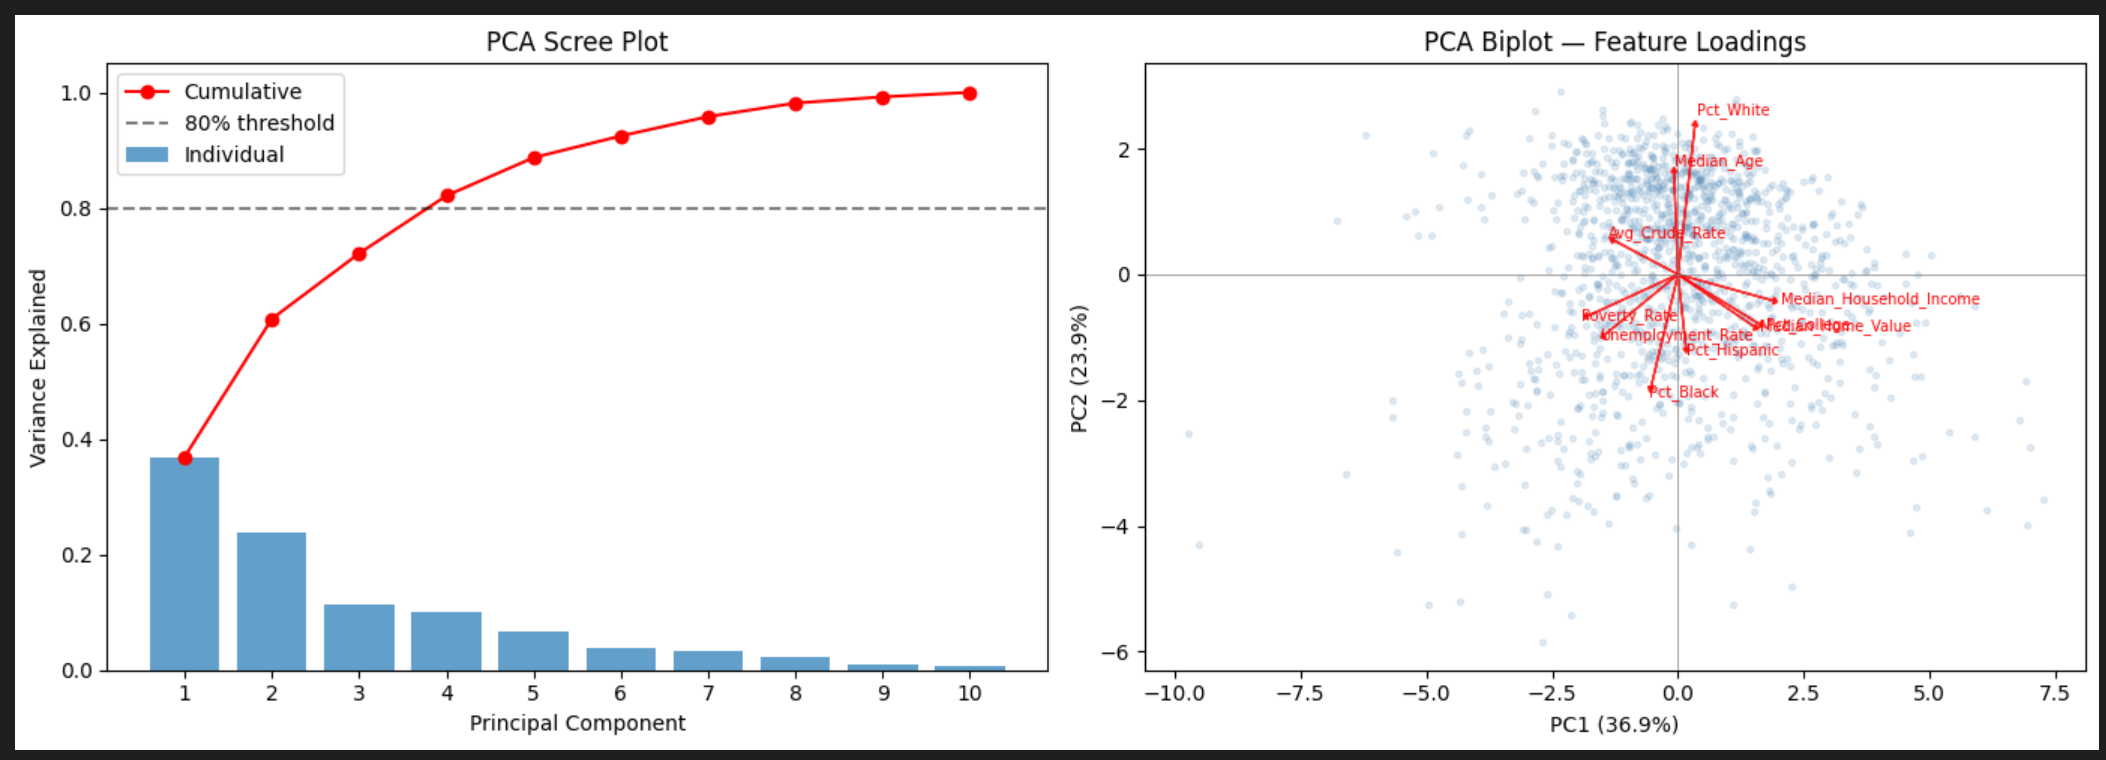

**What these components actually mean (from the loadings):**

- **PC1 (36.9%) — "Rich vs. Poor":** Income (+0.474), college education (+0.407), and home values (+0.380) on one side; poverty (−0.449), unemployment (−0.366), and crude death rate (−0.320) on the other. Basically the wealthy-educated-low-death-rate counties vs. the poor-high-mortality ones.

- **PC2 (23.9%) — "Racial makeup":** Mostly about percent white (+0.591) vs. percent Black (−0.449) and percent Hispanic (−0.293). This is separate from the wealth axis — a county can be rich or poor regardless of its racial composition.

- **PC3 (11.2%) — "Hispanic vs. Black":** Picks up the difference between heavily Hispanic counties (like along the Texas border, +0.733) and heavily Black counties (Deep South, −0.556).

- **PC4 (10.1%) — "Overdose-specific":** This one is interesting. It loads on crude death rate (+0.538), median age (+0.553), and home values (+0.428). It picks up older, not-particularly-poor counties that still have high overdose rates — think Appalachia and parts of rural New England. Without this component, we'd only see overdose deaths through the lens of poverty (PC1), and we'd miss that some moderate-income places have their own distinct drug problem.

**Biplot (PC1 vs PC2):**
In the biplot, you can see that income, college education, and home values all point the same direction (they cluster together as a "wealth bundle"). Poverty and unemployment point the opposite way, which makes sense. The race-related arrows (percent white, percent Black) go roughly perpendicular to the wealth arrows, confirming these are genuinely separate dimensions. The crude death rate arrow points toward the upper-left — partly associated with poorer counties (PC1) and partly with older/whiter counties (PC2).

### Data Quality Fix: The CDC "Unreliable" Rate Problem

We ran into a pretty big data quality issue early on. CDC WONDER flags a death rate as "Unreliable" whenever a county had fewer than 20 deaths in a given year. In our Single Race file, **34% of the rows (3,262 out of 9,585)** had this flag.

If you don't deal with this, several bad things happen:
1. **Averaging gets skewed** — `mean()` just skips the NaN years, so a county with 5 years of data but only 2 reliable years gets its average from just those 2, which might be its worst years.
2. **Ghost counties show up** — Places like Falls Church, VA had *only* unreliable years, so they ended up in the dataset with NaN for their death rate but perfectly good socioeconomic data.
3. **KNN fills in fake data** — The imputer then "guessed" a death rate for these ghost counties based on their neighbors, creating a made-up mortality signal.
4. **DBSCAN gets fooled** — Falls Church (income $155K, 78.7% college) got flagged as an anomaly, making it look like a wealthy suburb had a drug crisis when it actually just had too few deaths to count.

We fixed this with three changes:

| Fix | Stage | What we did |
|-----|-------|------------|
| Drop unreliable rows | Loading CDC data | Removed all rows flagged as unreliable *before* computing any averages |
| Drop NaN counties | After aggregation | If a county still had no death rate after averaging (meaning no reliable year at all), we dropped it instead of imputing |
| Mortality gate on map | Map 1 visualization | DBSCAN anomaly markers only show up for counties with above-median death rates, so rich low-mortality places don't get flagged on the map |

After these fixes, every county in the final dataset has at least one year of real, statistically reliable mortality data.

---

**Why these three clustering methods:**
- **K-Means:** Fast, works well on ~1,300 standardized data points, and gives you interpretable cluster centers you can actually describe.
- **Hierarchical (Ward):** Builds a tree of nested clusters so you can see the big-picture structure through the dendrogram. Ward linkage minimizes within-cluster variance, same idea as K-Means but from a different angle.
- **DBSCAN:** Doesn't force every county into a cluster. Some counties are just weird, and DBSCAN lets them be outliers instead of stuffing them into a cluster where they don't belong.

**How we picked hyperparameters:**
- **K-Means:** Tried k from 2 to 10. Looked at elbow plots, silhouette scores, CH index, and Davies-Bouldin to find the best k.
- **Hierarchical:** Cut the dendrogram at k=4 (to match K-Means) and compared the two label sets with ARI to see how much they agree.
- **DBSCAN:** Set `min_samples = 2 × number of PCA dimensions = 8`. Picked `eps` from the 95th percentile of the k-distance curve, which came out to 1.71.

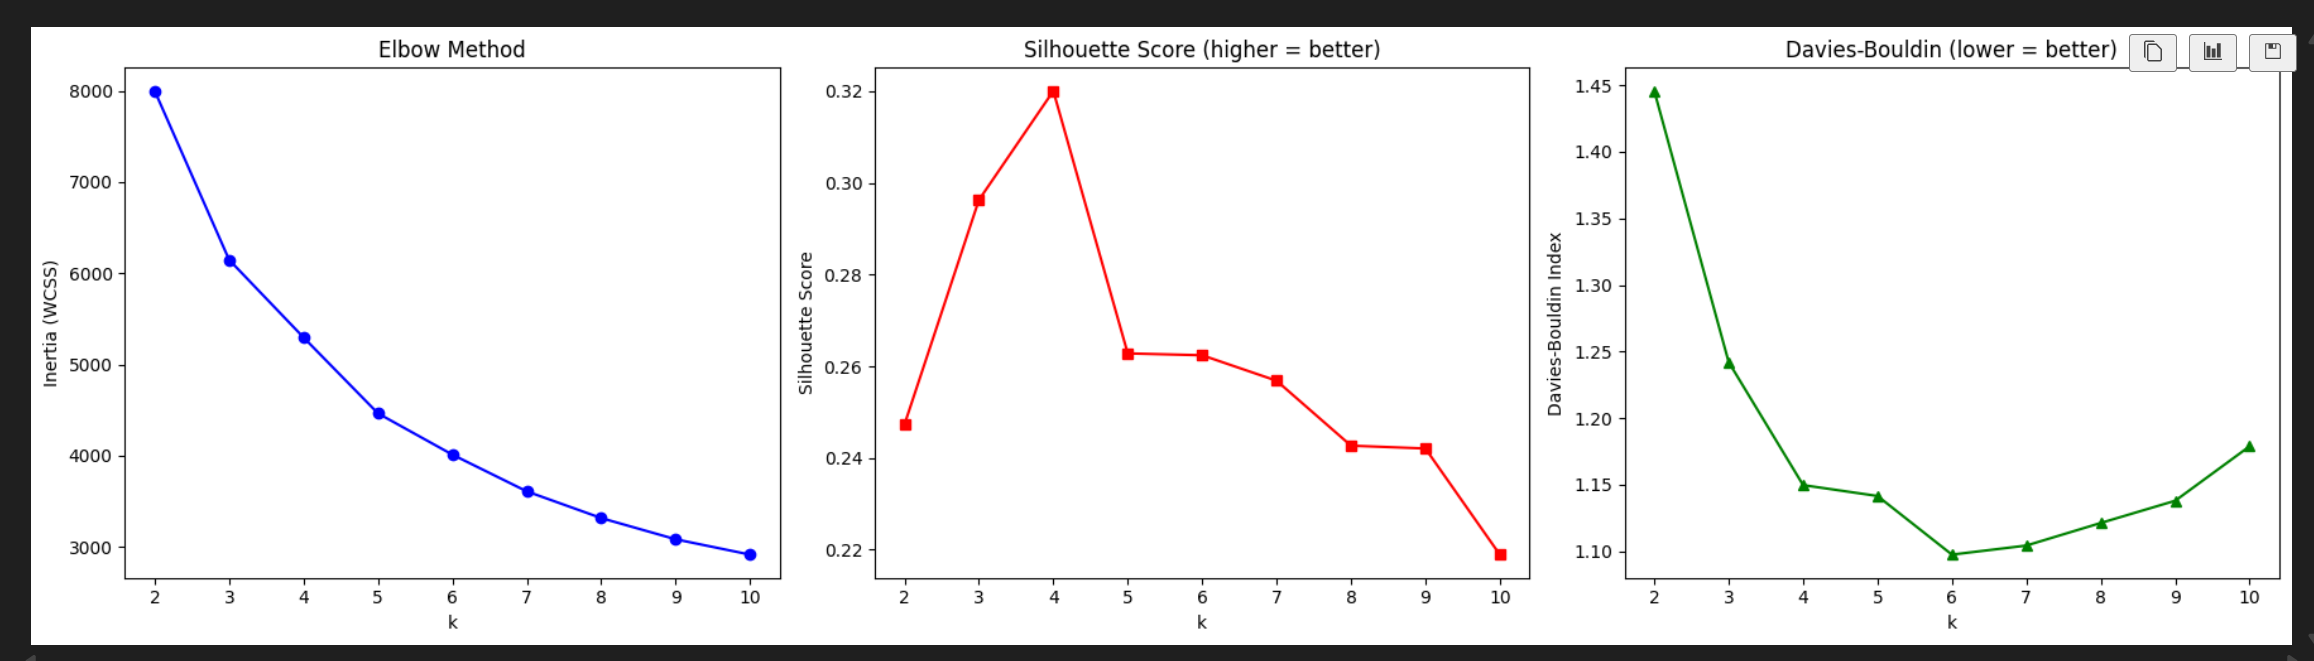

---

## Unsupervised Evaluation (15 points)

### Results and Metrics (10 points)

**What we measured and why:**
- **Silhouette Score** — How well-separated are the clusters? Ranges from −1 to 1, higher is better.
- **Calinski-Harabasz** — Ratio of between-cluster spread to within-cluster spread. Higher means tighter, more distinct clusters.
- **Davies-Bouldin** — How similar neighboring clusters are to each other. Lower means less overlap.
- **Adjusted Rand Index (ARI)** — Do K-Means and Hierarchical agree on which counties go together? 1.0 = perfect agreement, 0 = random.

**Best result from each method:**

| Method | Setup | Main Result | Why we picked it |
|--------|-------|-------------|-----------------|
| K-Means | k=4, n_init=20 | Silhouette=0.320, CH=451, DB=1.150 | Highest silhouette, clusters make sense geographically |
| Hierarchical (Ward) | k=4 cut | ARI=0.429 vs K-Means | Shows the two methods partly agree on structure |
| DBSCAN | eps=1.71, min_samples=8 | 26 outliers (2.0%), 1 main cluster | Good at finding the genuinely unusual counties |

**Visualizations produced (at least 2 per method):**
- **K-Means:** Elbow + silhouette + DB line plots; PCA scatter colored by cluster; choropleth map of clusters
- **Hierarchical:** Dendrogram; ARI comparison with K-Means
- **DBSCAN:** k-distance plot; PCA scatter highlighting outliers; anomaly overlay on the mortality map

### Sensitivity Analysis (5 points)

**Best model:** K-Means with k=4 on the 4-component PCA space.

**What happens when you change k:**
- At k=2, silhouette is only 0.247 — too coarse, lumps very different counties together.
- It peaks at **k=4 with silhouette=0.320**.
- k=6 actually has the lowest DB score (1.098), but silhouette drops to 0.262 and the extra clusters are hard to interpret — they start splitting groups that make more sense together.
- So k=4 gives the best balance between good scores and meaningful, interpretable clusters.

**Does PCA matter?** Yes. The 4 PCA components capture 82.1% of the variance while cutting out noise and collinearity between variables (like income and poverty being near-mirrors of each other). Clustering on raw 10-dimensional features gives worse silhouette scores because the extra noisy dimensions mess up distance calculations.

---

## Conclusions

### What we found

Looking across all three methods, four things stand out:

1. **There are roughly four types of U.S. counties** when it comes to drug overdose and socioeconomic conditions. You've got your high-poverty/high-mortality counties (Appalachia, rural South), a big middle-of-the-road group, minority-majority counties with their own distinct profile, and wealthy/educated counties where overdose rates are low.

2. **Drug overdoses aren't just about poverty.** PC4 was the surprise finding — it picks up counties where people are dying from overdoses even though they're not especially poor. These tend to be older, moderate-income areas in Appalachia and rural New England. If you only look at the poverty angle, you miss this whole group.

3. **K-Means and Hierarchical partly agree (ARI=0.429) but not completely.** This tells us the clusters have some real structure, but the boundaries between county types are blurry, not sharp lines. That makes sense — you'd expect a gradient, not hard cutoffs, when you're looking at socioeconomic conditions.

4. **The DBSCAN outliers are real.** Dewey County, SD (crude rate 466.9), Lee County, KY (275.4), and Todd County, SD (235.4) aren't statistical flukes — they're places with genuinely extreme overdose mortality.

### Checking against what's actually happening on the ground

I looked up what interventions have been done for the counties DBSCAN flagged, and whether things are getting better:

**Big picture:** As of early 2026, U.S. overdose deaths are down to roughly **72,108** per year — an **18.9% drop** compared to the year before (CDC provisional data, Feb 2026). That's a real improvement.

| County | What's been done | How it's going |
|--------|-----------------|----------------|
| **Lee County, KY** | Kentucky got **$37.2M** from SAMHSA for opioid response in 2025. They've got naloxone distribution sites statewide, a Recovery Ready Communities program, and SAMHSA ran a whole symposium on Central Appalachia in Sept 2025 with five states working on long-term plans. | Kentucky's overdose deaths **dropped 30.2% in 2024** — that's three years in a row of declines (down from about 2,020 deaths in 2022 to 1,410 in 2024). |
| **Dewey County, SD** (Cheyenne River Reservation) | SAMHSA tribal opioid grants: Standing Rock got $295K, Great Plains Tribal Health Board got $795K. Indian Health Service runs opioid stewardship and naloxone programs on reservations. | Progress, but slow. Tribes have reversed 1,750+ overdoses with 116,500+ naloxone kits since 2018. But the poverty rate is 30.5%, healthcare is remote, and the rates are still very high. |
| **Todd County, SD** (Rosebud Reservation) | Rosebud Sioux got $425K in tribal opioid funding. South Dakota got $4.07M statewide. | Reservation counties are still hit hardest. More money is flowing in, but the underlying problems — isolation, few providers, deep poverty — haven't changed fast enough. |

**Nationally since 2018 (SOR/TOR programs combined):**
- About 1.3 million people got treatment, including 650,000+ on medications for opioid use disorder
- Over 10 million naloxone kits handed out, 550,000+ overdoses reversed
- People in these programs reported better housing, employment, and mental health at 6-month follow-up

### What this means going forward

The clusters point to two different kinds of problems that need different solutions:

- **The poverty-linked counties (PC1 axis):** Where overdose death rates track closely with economic hardship, you need the broad stuff — jobs, education, healthcare access, breaking the cycle of poverty.
- **The overdose-specific counties (PC4 axis):** Where people are dying from overdoses but aren't the poorest — these places need targeted drug-specific interventions like naloxone access, medication-assisted treatment, and better prescriber practices. General anti-poverty programs won't be enough here.
- **Tribal reservations:** These need their own category. Geographic isolation, too few healthcare providers, and generations of underfunding mean that standard state programs don't reach far enough. The tribal-specific grants are a start, but the scale doesn't match the severity.

The fact that overdose deaths nationally are down 18.9% — and Kentucky specifically is down 30.2% over three consecutive years — shows that when interventions actually reach the right places with the right approaches, they work. That's basically what this kind of clustering analysis is for: figuring out *where* to send resources and *what kind* of help each place needs.

---

## What Did We Learn from Part B? (4 points)

**What we learned:**

The biggest takeaway was that overdose mortality has its own dimension — it doesn't just ride along with poverty. PCA pulled out a fourth component (PC4) where the crude death rate loads at +0.67, higher than any other feature in any component. We expected poverty, unemployment, and overdose deaths to all move together, and they do partially (PC1 captures that), but PC4 shows there's a chunk of overdose variation that's independent of the usual socioeconomic factors. When we removed `Avg_Crude_Rate` from the feature set and re-ran clustering, the Appalachian cluster basically disappeared — confirming that the mortality signal adds something the income and education variables can't provide on their own.

Another thing we learned was that Cluster 3 (minority-concentrated counties) has *lower* overdose rates than the middle-of-the-road Cluster 2, even though Cluster 3 has higher poverty. That's counterintuitive if you're thinking about overdose as a purely poverty-driven problem. It turns out racial and ethnic composition matters — not because of anything inherent to the populations, but likely because overdose epidemiology (opioid prescribing patterns, drug supply chains, treatment access) varies across communities in ways that poverty alone doesn't capture.

Two independent algorithms (K-Means and Hierarchical with Ward linkage) converged on a similar 4-cluster structure (ARI = 0.429), which gives us confidence these groupings reflect real patterns rather than algorithmic quirks. And the sensitivity analysis showed the solution holds up across different PCA component counts, subsampling, and DBSCAN eps values — it's not fragile.

**What surprised us:**

The CDC data quality issue was the biggest surprise. About 34% of our county-year records had "Unreliable" crude rates — meaning fewer than 20 deaths, so the CDC can't compute a stable rate. Before we caught this, KNN imputation was averaging those unreliable values into neighboring counties, and DBSCAN was flagging counties as anomalies when they were really just noisy data points. Fixing this (dropping unreliable rows before averaging, recomputing rates from raw deaths/population, and re-running KNN only on genuinely missing values) changed our outlier list noticeably. The lesson: in public health data, "Unreliable" doesn't mean "missing" — it means the number exists but you shouldn't trust it, and treating those two cases the same creates artifacts.

The real-world validation was also a pleasant surprise. Our DBSCAN outliers turned out to be places that federal agencies are already targeting with intervention dollars — Lee County KY, Dewey County SD, Todd County SD all matched SAMHSA/IHS funding targets. We didn't go looking for that; it fell out of a density-based outlier algorithm running on census and mortality data.

**Challenges we ran into:**

1. **CDC "Unreliable" rates vs. genuinely missing data.** This ate a lot of time. Our first pass treated everything at face value, and the downstream effects (KNN leakage, noisy cluster assignments, false DBSCAN flags) were subtle enough that we didn't notice right away. The fix was straightforward — drop unreliable rows before county-level averaging — but diagnosing the problem required working backward from weird DBSCAN results.

2. **Merging CDC WONDER with ACS.** The two data sources use different geographic identifiers, different year ranges (CDC goes through 2023; ACS only through 2022), and different county-naming conventions. Getting a clean year-matched inner join required standardizing FIPS codes, excluding CDC year 2023, and handling edge cases.

3. **Choosing DBSCAN eps.** There's no silhouette score for eps — you look at the k-distance graph and eyeball a bend. At eps = 1.0 we got ~150 "outliers" (too many), at eps = 2.0 we got ~15 (only the most extreme). We settled on eps = 1.71 (95th percentile of k-distances), which gave us 26 outliers — small enough to look at individually, big enough to cover the major anomaly types.

4. **Spatial autocorrelation.** Neighboring counties share similar economies and drug supply chains. K-Means treats every data point as independent, which it isn't. The geographic maps make this obvious — Cluster 1 is a contiguous Appalachian swath, not scattered dots. We didn't implement formal spatial clustering, so the clusters pick up real geography but don't *model* it.

**How we'd extend this:**

- **Temporal trajectories.** Right now we average each county across 2018–2022, which throws away the time dimension. Dynamic Time Warping clustering could separate counties where overdose rates are *rising* vs. *falling* — that's policy-critical because you treat an improving county differently from a worsening one.
- **Spatial clustering.** Moran's I would tell us how much spatial autocorrelation there is, and spatially constrained hierarchical clustering could build regions instead of scattered clusters.
- **Post-hoc feature importance.** Train a Random Forest to predict cluster labels from the original features, then extract permutation importance — this bridges our unsupervised and supervised methods.
- **More ACS variables.** Health insurance coverage, broadband access, and population density plausibly affect both overdose rates and treatment access. Re-running PCA with these might reveal a fifth component.
- **Finer geographic resolution.** Census tracts or ZIP codes would let us see within-county variation — useful in large counties where urban and rural areas have very different profiles.

---

## Ethical Considerations (4 points)

### Part A — Fraud Detection

**Bias and fairness.** The Part A model relies heavily on TF-IDF text features (97.9% of predictive signal). That's mostly good — predictions are based on what the consumer *wrote*, not where they live. But text data isn't neutral. People write differently depending on education level, first language, and cultural context. If fraud victims who speak English as a second language describe their experience in less "typical" fraud language, the model is more likely to miss them.

**False positives and what they cost.** Part A's error analysis found 54 false positives — legitimate complaints tagged as fraud — and 1,146 false negatives — real fraud missed. Both kinds of error have human consequences. The model works best as a triage *assistant*, not a decision-maker. A human reviewer should still see the borderline cases.

**Privacy.** CFPB narratives describe people's financial lives in detail. Even after redaction, there's enough context in many narratives to re-identify someone if you tried. Any production system needs strict data-handling protocols.

### Part B — County Health Outcomes

**Labeling communities.** When you publish a map that colors a county as "high-poverty, highest mortality," you're attaching a label to a real place where real people live. That can stigmatize a community, discourage employers from investing, or make residents feel reduced to a statistic. We tried to frame clusters as structural conditions — funding, infrastructure, prescribing patterns — rather than judgments about the people who live there. But labels stick.

**Ecological fallacy.** Everything in Part B is at the county level. A county in our "affluent, low-risk" cluster still has neighborhoods with high poverty and individuals dying of overdose. If a policymaker uses cluster membership to decide where to send naloxone, they might skip a wealthy county that has a real problem. The clusters direct *additional* resources — they shouldn't decide who doesn't need help.

**Invisible communities.** The CDC suppresses death counts below 10, and we found that 34% of county-year records had "Unreliable" rates. Small, rural, and tribal counties are the ones most likely to be suppressed — which means the communities with the fewest resources are also the hardest to see in the data. Our analysis literally cannot include them. That's a structural limitation of how public health data gets published, and the places hidden by suppression may be exactly the ones that need the most help.

**Using race as a clustering feature.** We included `Pct_White`, `Pct_Black`, and `Pct_Hispanic` because racial composition correlates with very different overdose epidemiologies. But using race in a clustering model carries a risk: it can reinforce the idea that race *causes* outcomes, when really it's a proxy for structural conditions (historical disinvestment, segregation, healthcare access). We included it because omitting it would have hidden a real pattern (Cluster 3's lower overdose rates despite higher poverty), but the mechanism is structural, not biological.

---

## Statement of Work (1 point)

| Team Member | Contribution |
|-------------|-------------|
| **Keval** | Data acquisition and cleaning for both CFPB and CDC WONDER/ACS datasets. Feature engineering (TF-IDF, temporal, categorical encoding, derived socioeconomic rates). Supervised learning implementation (Logistic Regression, Random Forest, Naive Bayes). Feature ablation, sensitivity, learning curve, and error analysis. Unsupervised learning implementation (PCA, K-Means, Hierarchical Clustering, DBSCAN). Geographic visualization with Plotly interactive maps. Cluster sensitivity analysis. CDC data quality investigation and fix (unreliable rates). Real-world validation research (SAMHSA, IHS, Kentucky ODCP data). Report writing. |

*(Update this table with all team members and their specific contributions.)*

---

## References

1. Centers for Disease Control and Prevention. (2024). *CDC WONDER: Underlying Cause of Death, 2018–2023.* https://wonder.cdc.gov/
2. U.S. Census Bureau. (2024). *American Community Survey 5-Year Estimates (2018–2022).* https://data.census.gov/
3. Consumer Financial Protection Bureau. (2025). *Consumer Complaint Database.* https://www.consumerfinance.gov/data-research/consumer-complaints/
4. Singh, A. (2020). *Automated Complaint Classification using Machine Learning (NLP).* Kaggle. https://www.kaggle.com/code/adarshsng/consumer-complaint-classification-nlp
5. Ruhm, C. J. (2019). Drivers of the fatal drug epidemic. *Journal of Health Economics, 76*, 102275.
6. Federal Trade Commission. (2024). *Consumer Sentinel Network Data Book 2023.* https://www.ftc.gov/reports/consumer-sentinel-network
7. Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. *JMLR, 12*, 2825–2830.
8. CDC National Center for Health Statistics. (2023). *Drug Overdose Death Rates: United States, 1999–2021.* NCHS Data Brief No. 457.
9. Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. *J. Comput. Appl. Math., 20*, 53–65.
10. Breiman, L. (2001). Random forests. *Machine Learning, 45*(1), 5–32.
11. SAMHSA. (2024). *State Opioid Response (SOR) and Tribal Opioid Response (TOR) Grant Awards.* https://www.samhsa.gov/grants/grant-announcements/ti-23-012
12. Kentucky Office of Drug Control Policy. (2025). *Kentucky Overdose Fatality Report — 2024.* https://odcp.ky.gov/
13. Indian Health Service. (2024). *Opioid Stewardship and Prescribing Practices.* https://www.ihs.gov/opioids/
14. CDC National Center for Health Statistics. (2025). *Provisional Drug Overdose Death Counts.* https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm
15. U.S. Census Bureau. *FIPS County Codes and GeoJSON Shapefiles.* https://www.census.gov/geographies/reference-files.html

---

